In [1]:
import cv2, collections
import numpy as np
import matplotlib.pyplot as plt
import math
# import seaborn as sns
from queue import Queue

In [5]:
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
color = (0, 255, 0)
first_frame = cv2.imread("../images/2016_04_07_07_09_21FrontColor_IN/frames/frame0.jpg")
# first_frame = cv2.imread("images/trial1/frame60.jpg")

prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
prev = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)
mask = np.zeros_like(first_frame)

T = 7.5          # threshold on the amount of movement recognized
K = 5000            # the amount of seeds chosen for bfs

# takes position(i,j), visited matrix, motion vector matrix and threshold on vector magnitude
def bfs(i, j, vis, mag, t, region):
#     print(i,j)
    util = [-1, 0, 1]
    if mag[i][j] < t or vis[i][j] == True:
        return 0
    q = collections.deque()
    area = 0
    vis[i][j] = True
    q.append([i,j])
    while len(q) > 0:
        curX, curY = q.popleft()
        region[curX][curY] = 255
        area += 1
        for a in range(3):
            for b in range(3):
                x = curX + util[a]
                y = curY + util[b]
                if x >= 0 and y >= 0 and x < mag.shape[0] and y < mag.shape[1] and vis[x][y] != True:
                    vis[x][y] = True  
                    if mag[x][y] >= t:
                        q.append([x, y])
    return area
    
# plot = plt.figure(figsize=(100,100))

for index in range(1,50):
    frame = cv2.imread("../images/2016_04_07_07_09_21FrontColor_IN/frames/frame"+ str(index)+".jpg")
#     frame = cv2.imread("images/trial1/frame"+ str(i)+".jpg")
    
    # plot.add_subplot(10, 2, 2*index-1)
    # plt.imshow(prev_gray, cmap='gray')
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = gray.copy()
    prev = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

    # motion estimation
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 1, 5, 2, 5, 1.1, None)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # considering only vertical motion
    vertical = mag.copy()
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            vertical[i][j] = mag[i][j] * abs(np.sin(ang[i][j]))

    # calculating varying T
    ind = 0
    temp_array = [0]*(vertical.shape[0]*vertical.shape[1])
    for i in range(vertical.shape[0]):
        for j in range(vertical.shape[1]):
            temp_array[ind] = vertical[i][j]
            ind += 1
    temp_array = np.array(temp_array)
    temp_array = np.sort(temp_array)[::-1]
    # top 5%
    percent = (2*mag.shape[0]*mag.shape[1])/100
    percent = int(percent)
    print(temp_array[percent-1])
    # ax = sns.heatmap(mag)
    # plt.show()
    T = temp_array[percent-1]
    if T < 1:
        T = 1
    # Calculating feature value M
    dy, dx = np.gradient(gray)
    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy
    R_score = np.array(gray.copy(),dtype=np.float64)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            sum_Ix = 0
            sum_Iy = 0
            sum_Ixy = 0
            for k in range(-2,3):
                for l in range(-2,3):
                    if i+k >= 0 and j+l >= 0 and i+k < gray.shape[0] and j+l < gray.shape[1]:
                        sum_Ix += Ixx[i+k][j+l]
                        sum_Iy += Iyy[i+k][j+l]
                        sum_Ixy += Ixy[i+k][j+l]
                    else:
                        sum_Ix += 0
                        sum_Iy += 0
                        sum_Ixy += 0
            det = sum_Ix*sum_Iy - sum_Ixy*sum_Ixy
            trace = sum_Ixy + sum_Ixy
            r = det - 0.05*(trace**2)
            R_score[i][j] = r 
    min_val = np.min(R_score)
    R_score += (-1)*min_val
    max_val = np.max(R_score)
    R_score = (R_score/max_val)*255
    R_score = R_score.astype(int)
    
#     print(np.max(ang), np.min(ang), "angles")
    # ax = sns.heatmap(R_score)
    # plt.show()
    listOfFeatures = []
    listTemp = []
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            listTemp.append([R_score[x][y], x, y])
    listTemp.sort()
    listTemp.reverse()
#     print(listTemp[0],listTemp[-1])
    for x in range(len(listTemp)):
        listOfFeatures.append(listTemp[x])
    
    # break
    region = np.zeros((frame.shape[0], frame.shape[1]), dtype=int)
    vis = [[False for x in range(frame.shape[1])] for y in range(frame.shape[0])]
    for point in listOfFeatures:
        area = bfs(point[1], point[2], vis, vertical, T, region)
#         print(np.max(region), np.min(region))
        # do something with the area if we want to
    # plot.add_subplot(10, 2, 2*index)
    # plt.imshow(region, cmap='gray')
#     plt.show()
    
#     break
    prev_gray = gray.copy()
#     prev = good_new.reshape(-1, 1, 2)
    mask = np.zeros_like(frame)
    plt.imsave('../images/2016_04_07_07_09_21FrontColor_IN/motion_vect_try1/frame'+ str(index)+'.jpg',region)

3.1300528
2.7200022
4.400181
5.3840804
8.862828
9.022716


In [6]:
def new_bfs(img,r,c,col,vis):
    h,w = img.shape
    q = Queue()
    q.put((r,c))
    vis[r,c] = 1
    cnt = 0
    while not q.empty():
        cnt += 1
        r, c = q.get()
        if r-1>=0 and vis[r-1,c] == 0 and img[r-1,c]!=0:
            vis[r-1,c] = col
            q.put((r-1,c))
        if r+1<h and vis[r+1,c] == 0 and img[r+1,c]!=0:
            vis[r+1,c] = 1
            q.put((r+1,c))
        if c-1>=0 and vis[r,c-1] == 0 and img[r,c-1]!=0:
            vis[r,c-1] = 1
            q.put((r,c-1))
        if c+1<w and vis[r,c+1] == 0 and img[r,c+1]!=0:
            vis[r,c+1] = 1
            q.put((r,c+1))
            
    return cnt

In [37]:
def component_labelling(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     plt.imshow(img, cmap='gray')
#     plt.title('original image')
#     plt.xticks([]), plt.yticks([]) 
#     plt.show()

    # taking OSTU's threshold for best results
    th, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img = (img > th).astype(np.uint8)
#     plt.imshow(img, cmap='gray')
#     plt.title('image thresholding')
#     plt.xticks([]), plt.yticks([]) 
#     plt.show()

    img = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 3)
#     plt.imshow(img, cmap='gray')
#     plt.title('dilation')
#     plt.xticks([]), plt.yticks([]) 
#     plt.show()
    
    vis = np.zeros(img.shape)
    h,w = img.shape
    arr = []
    sum = 0
    for i in range(h):
        for j in range(w):
            if vis[i,j]==0 and img[i,j]==1:
                cnt = new_bfs(img,i,j,1,vis)
                sum += cnt
                arr.append((i,j,cnt))

    
    # this k will determine if, the connected component will be considered background or not?
    k = 7000 #by looking at the values of connected component, this seemed to be a resonable number    
        
    fin_arr = []
    for i in range(len(arr)):
        if arr[i][2] >= k:
            fin_arr.append((arr[i][0],arr[i][1]))

    vis = np.zeros(img.shape)
    c = 1
    for i in range(len(fin_arr)):
        cnt = new_bfs(img,fin_arr[i][0],fin_arr[i][1],c,vis)
        c += 1

#     print('number of regions of interest are: ',len(fin_arr))
    
    # COLORING     
    COLORS = [(255,0,255), (0,255,255), (255, 0, 0), (0, 255, 0), (0,0,255), (255,255,0)]
    final_img = np.zeros((h, w,3), int)
#   done for one centroid only as of now  
    cnt = 0
    cent_x = 0.0
    cent_y = 0.0
    for i in range(h):
        for j in range(w):
            if vis[i,j] != 0:
                col = math.floor(vis[i,j]%6)   #we have 6 colors in above array
                final_img[i,j,0] = COLORS[col][0] 
                final_img[i,j,1] = COLORS[col][1] 
                final_img[i,j,2] = COLORS[col][2] 
                
                cent_x += i
                cent_y += j
                cnt += 1
                
    cent_x = cent_x//cnt
    cent_y = cent_y//cnt
    
    print('Centroid of the image is at: ',cent_x, cent_y)
                
    plt.imshow(final_img)
    plt.title('region of interset: colored')
    plt.xticks([]), plt.yticks([]) 
    plt.show()

Centroid of the image is at:  53.0 159.0


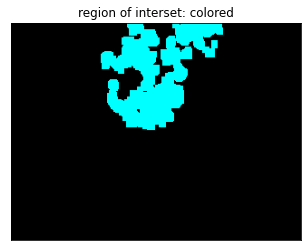

Centroid of the image is at:  65.0 121.0


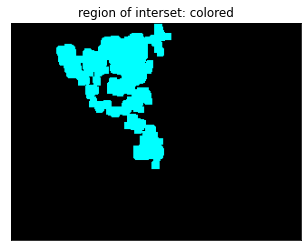

Centroid of the image is at:  51.0 167.0


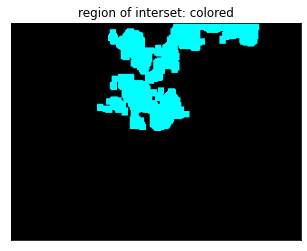

Centroid of the image is at:  102.0 134.0


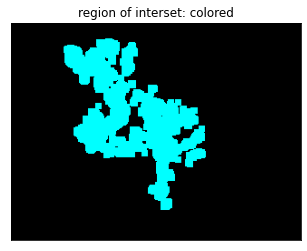

Centroid of the image is at:  82.0 130.0


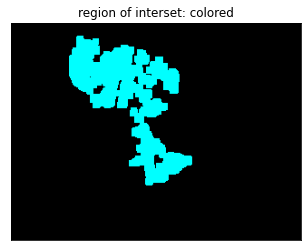

Centroid of the image is at:  84.0 119.0


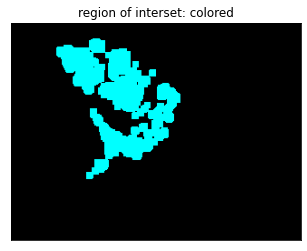

Centroid of the image is at:  118.0 148.0


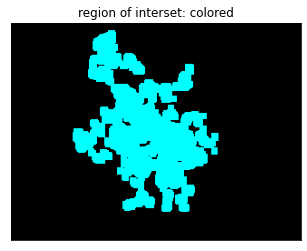

Centroid of the image is at:  120.0 163.0


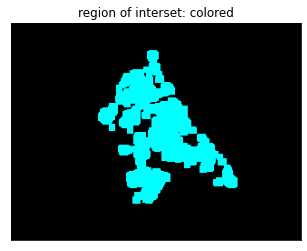

Centroid of the image is at:  123.0 136.0


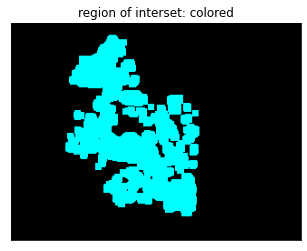

In [38]:
# working on output frames
c = 0
while c<9:
    img_path = "../output_trial/frame"+ str(c)+".jpg"
    component_labelling(img_path)
    c+=1